## In this file we will implement a fully-connected neural network using numpy and PyTorch! 
### We will:
* Understand backpropagation and forward pass
* Use Numpy to build the computational graph of forward and backward pass
* Understand API of PyTorch
* Understand the pipeline of developing a Neural Network


### First we need to import some python libraries.

In [93]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'


# PyTorch preparation
USE_GPU = True
dtype = torch.float32

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print("using device:", device)

%load_ext autoreload
%autoreload 2

using device: cuda
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Now we can move on to preprocess some data**\
As the first neural net, I'm just gonna generate data to form the sin(x) function and use our trained model to fit the data.

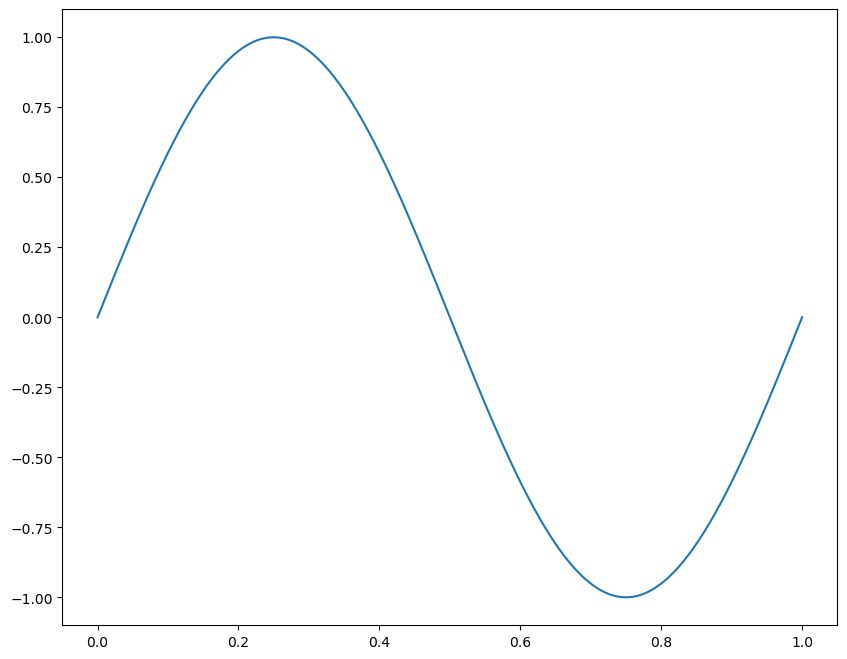

In [151]:
np.random.seed(0)
N = 500    # Number of points we can fit
x = np.linspace(0, 1, num=N).reshape(N, 1)    # Create a linear space between -2*pi and 2*pi
y = np.sin(2*np.pi*x)
# Now we can plot these points
plt.plot(x, y)
plt.show()

Iteration:0, current loss: 1.265418
Iteration:1, current loss: 14.859968
Iteration:2, current loss: 11.080011
Iteration:3, current loss: 0.471209
Iteration:4, current loss: 0.450012
Iteration:5, current loss: 0.437380
Iteration:6, current loss: 0.428764
Iteration:7, current loss: 0.422734
Iteration:8, current loss: 0.418329
Iteration:9, current loss: 0.414908
Iteration:10, current loss: 0.412061
Iteration:11, current loss: 0.409543
Iteration:12, current loss: 0.407210
Iteration:13, current loss: 0.404983
Iteration:14, current loss: 0.402819
Iteration:15, current loss: 0.400697
Iteration:16, current loss: 0.398605
Iteration:17, current loss: 0.396538
Iteration:18, current loss: 0.394492
Iteration:19, current loss: 0.392465
Iteration:20, current loss: 0.390458
Iteration:21, current loss: 0.388470
Iteration:22, current loss: 0.386500
Iteration:23, current loss: 0.384547
Iteration:24, current loss: 0.382613
Iteration:25, current loss: 0.380696
Iteration:26, current loss: 0.378797
Iteration

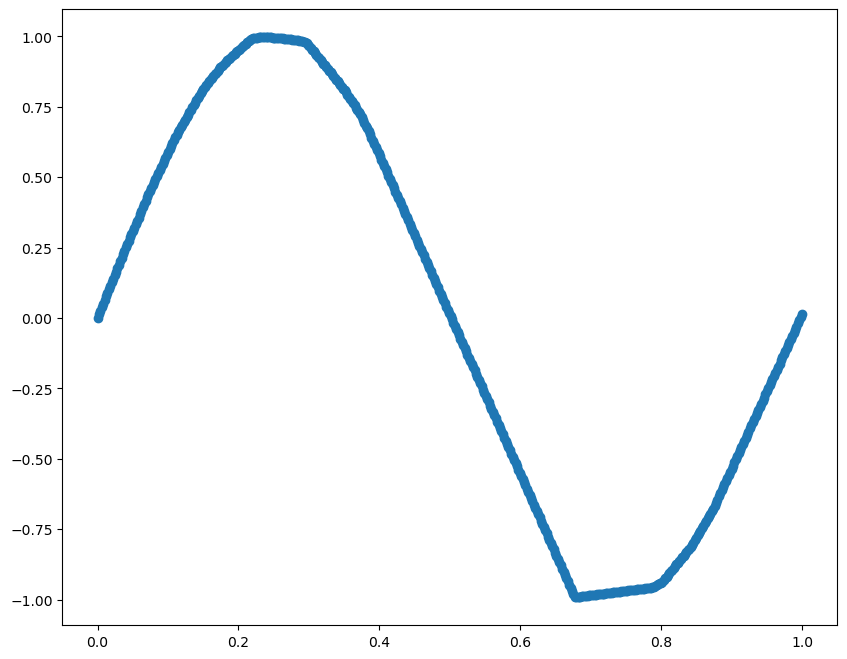

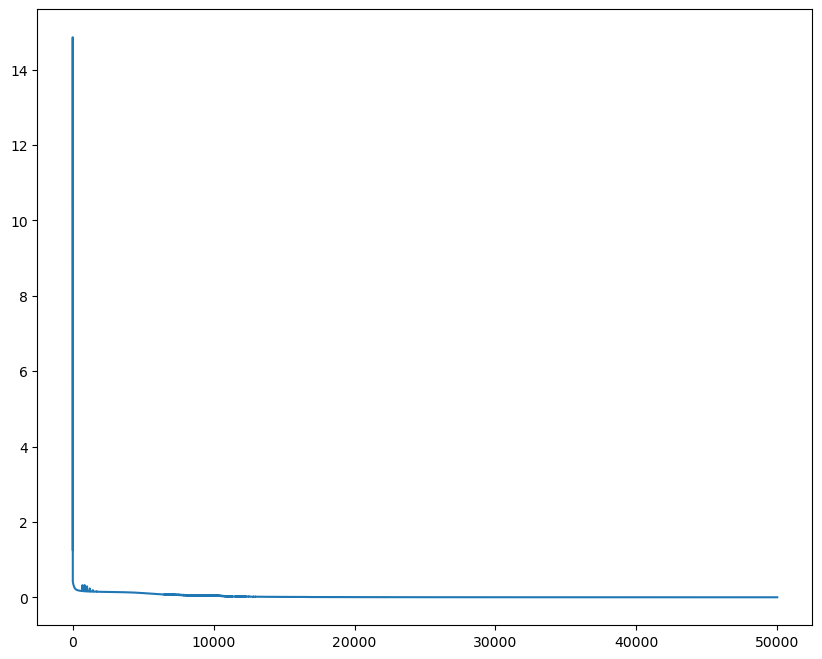

In [150]:
hidden_dim = [1000, 100]
W1 = np.random.normal(
    loc=0,
    size=(1, hidden_dim[0])
)
W1 = W1 * np.sqrt(2 / 1)
b1 = np.zeros(hidden_dim[0])

W2 = np.random.normal(
    loc=0,
    size=(hidden_dim[0], hidden_dim[1])
)

W2 = W2 * np.sqrt(2 / hidden_dim[0])

b2 = np.zeros(hidden_dim[1])

W3 = np.random.normal(
    loc=0,
    size=(hidden_dim[1], 1)
)
b3 = np.zeros(1)

W3 = W3 * np.sqrt(2 / hidden_dim[1])

loss_his = []
step_size = -1e-2

for i in range(50000):    # Iterate over the data 100000 times
    # Compute the values using weights and biases
    h1 =  x.dot(W1) + b1
    # Add non-linearality
    h1 = np.maximum(h1, 0)
    # Second Layer
    h2 = h1.dot(W2) + b2
    h2 = np.maximum(h2, 0)
    # Third Layer
    y_pred = h2.dot(W3) + b3

    # Compute the loss using mean squared loss
    loss = np.sum((y_pred - y) ** 2) / N
    loss_his.append(loss)
    # Compute the gradient of each parameter
    dy_pred = 2 * (y_pred - y) / N

    db3 = np.sum(dy_pred)
    dW3 = h2.T.dot(dy_pred)
    dh2 = dy_pred.dot(W3.T)

    dh2[h2 <= 0] = 0

    dW2 = h1.T.dot(dh2)
    db2 = np.sum(dh2, axis=0)

    dh1 = dh2.dot(W2.T)
    dh1[h1 <= 0] = 0

    dW1 = x.T.dot(dh1)
    db1 = np.sum(dh1, axis=0)


    W1 += step_size * dW1
    b1 += step_size * db1

    W2 += step_size * dW2
    b2 += step_size * db2

    W3 += step_size * dW3
    b3 += step_size * db3

    print("Iteration:%d, current loss: %f" % (i, loss))


h1 =  x.dot(W1) + b1
# Add non-linearality
h1 = np.maximum(h1, 0)
# Second Layer
h2 = h1.dot(W2) + b2
h2 = np.maximum(h2, 0)
# Third Layer
y_pred = h2.dot(W3) + b3

print(y_pred.shape)

plt.plot(x, y_pred, 'r')
plt.plot(x, y, 'b')
plt.legend(loc="best")
plt.show()

plt.plot(loss_his, '-')
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(500, 1)


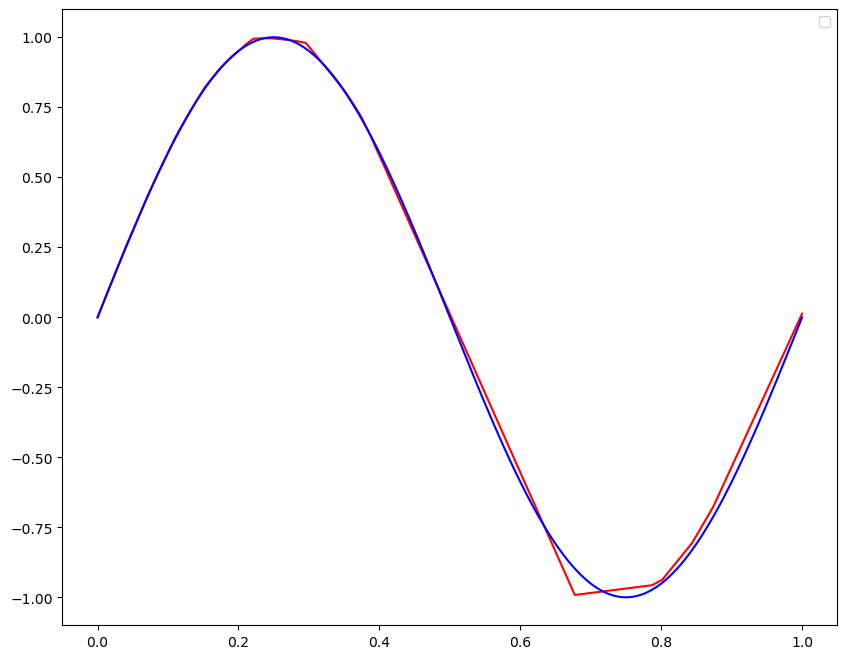

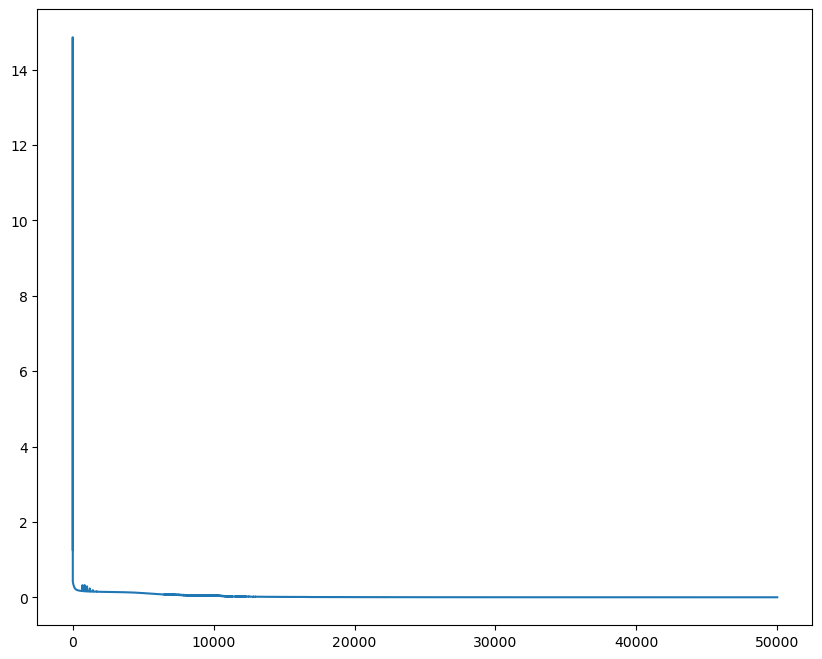

In [152]:
print(y_pred.shape)

plt.plot(x, y_pred, 'r')
plt.plot(x, y, 'b')
plt.legend(loc="best")
plt.show()

plt.plot(loss_his, '-')
plt.show()


### Now that we've seen how to implement a neural network in Numpy, let's try it with PyTorch

### PyTorch actually has three data abstraction.
Here is a table of comparison:

| API           | Flexibility | Convenience |
|---------------|-------------|-------------|
| Barebone      | High        | Low         |
| `nn.Module`     | High        | Medium      |
| `nn.Sequential` | Low         | High        |

First, we will implement a Neural Net with the lowest type of abstraction.\
Remember, our network structure is (Affine - ReLU - Affine - ReLu - Affine) with a Mean Squared Error as our loss function.

### Barebones Python

In [102]:
import torch.nn.functional as F
# Network structure: (Affine - ReLU - Affine - ReLu - Affine)
def three_layer_fc(x, params):
    """
    Inputs:
        - x: A Tensor shaped: (N x d1 x d2 x ... dk)
        - params: PyTorch Tensors giving weights and biases
    """
    w1, b1, w2, b2, w3, b3 = params
    h1 = F.relu(x.mm(w1) + b1)
    h2 = F.relu(h1.mm(w2) + b2)
    out = h2.mm(w3) + b3
    return out
    # return (F.relu((F.relu(x.mm(w1) + b1)).mm(w2) + b2)).mm(w3) + b3


def three_layer_fc_test():
    x = torch.zeros((500, 1), dtype=dtype)
    w1 = torch.zeros((1, 1000), dtype=dtype)
    b1 = torch.zeros(1000)
    w2 = torch.zeros((1000, 100))
    b2 = torch.zeros(100)
    w3 = torch.zeros(100, 1)
    b3 = torch.zeros(1)

    params = (w1, b1, w2, b2, w3, b3)
    out = three_layer_fc(x, params)
    return out.shape
three_layer_fc_test()

torch.Size([500, 1])

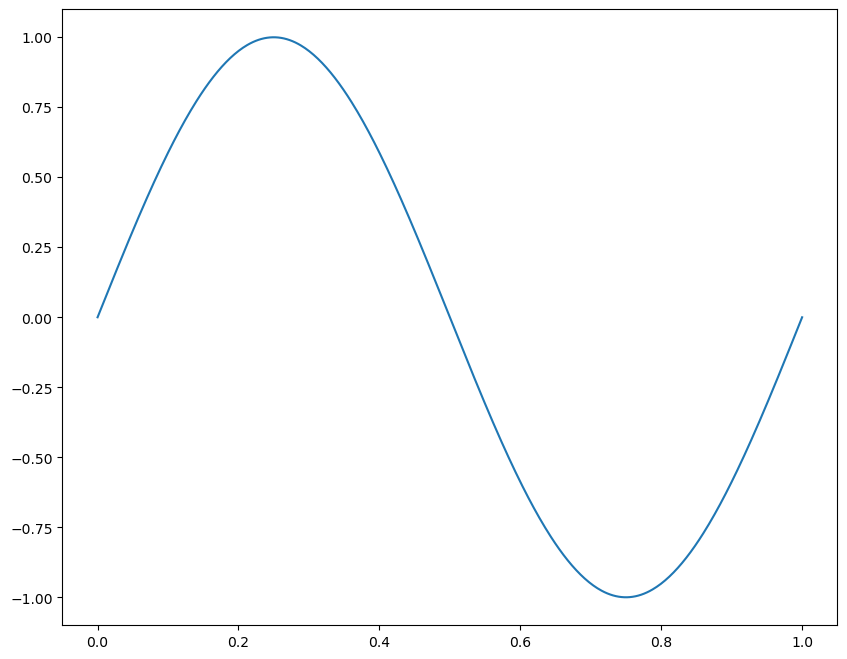

In [184]:
x_bare = torch.linspace(0, 1, steps=N).reshape(N, 1)
y_bare = torch.sin(2 * torch.pi * x_bare)

plt.plot(x_bare, y_bare)
plt.show()


### Train the neural network
Now that we have generated some raw data, we can train our network to approximate it.

* First, define a function to help us initialize our weights.

In [185]:
def random_weights(shape):
    if len(shape) == 2:
        fan_in = shape[0]
    else:
        fan_in = np.prod(shape[1:])
    
    w = torch.randn(shape, device=device, dtype=dtype) * np.sqrt(2 / fan_in)
    w.requires_grad = True
    return w

def zero_weights(shape):
    return torch.zeros(shape, device=device, dtype=dtype, requiers_grad=True)

In [186]:
def train_loop(x, y, model_fn, params, learning_rate, iteration=100):
    
    for i in range(iteration):
        
        y_pred = model_fn(x, params)
        loss = F.mse_loss(y_pred, y)
        
        loss.backward()

        with torch.no_grad():
            for w in params:
                w -= learning_rate * w.grad

                w.grad.zero_()

        print("Iteration %d, loss = %.4f" % (i, loss.item()))
    
    x_cpu = x.to(device=torch.device('cpu'))
    y_cpu = y.to(device=torch.device('cpu'))
    y_pred_cpu = y_pred.to(device=x_cpu.device)

    x_np = x_cpu.detach().numpy()
    y_np = y_cpu.detach().numpy()
    y_pred_np = y_pred_cpu.detach().numpy()

    
    plt.plot(x_np, y_pred_np, "r", label="prediction")
    plt.plot(x_np, y_np, "b", label="real")
    plt.legend(loc="best")
    plt.show()


Iteration 0, loss = 1.0696
Iteration 1, loss = 120.4148
Iteration 2, loss = 1.1975
Iteration 3, loss = 0.9976
Iteration 4, loss = 0.8665
Iteration 5, loss = 0.8319
Iteration 6, loss = 0.7995
Iteration 7, loss = 0.7691
Iteration 8, loss = 0.7403
Iteration 9, loss = 0.7131
Iteration 10, loss = 0.6872
Iteration 11, loss = 0.6625
Iteration 12, loss = 0.6389
Iteration 13, loss = 0.6180
Iteration 14, loss = 0.6201
Iteration 15, loss = 0.5828
Iteration 16, loss = 0.5636
Iteration 17, loss = 0.5638
Iteration 18, loss = 0.5452
Iteration 19, loss = 0.5432
Iteration 20, loss = 0.5326
Iteration 21, loss = 0.5108
Iteration 22, loss = 0.5243
Iteration 23, loss = 0.5166
Iteration 24, loss = 0.5054
Iteration 25, loss = 0.5117
Iteration 26, loss = 0.5109
Iteration 27, loss = 0.5076
Iteration 28, loss = 0.5045
Iteration 29, loss = 0.5009
Iteration 30, loss = 0.4923
Iteration 31, loss = 0.5162
Iteration 32, loss = 0.4995
Iteration 33, loss = 0.4972
Iteration 34, loss = 0.4934
Iteration 35, loss = 0.4810


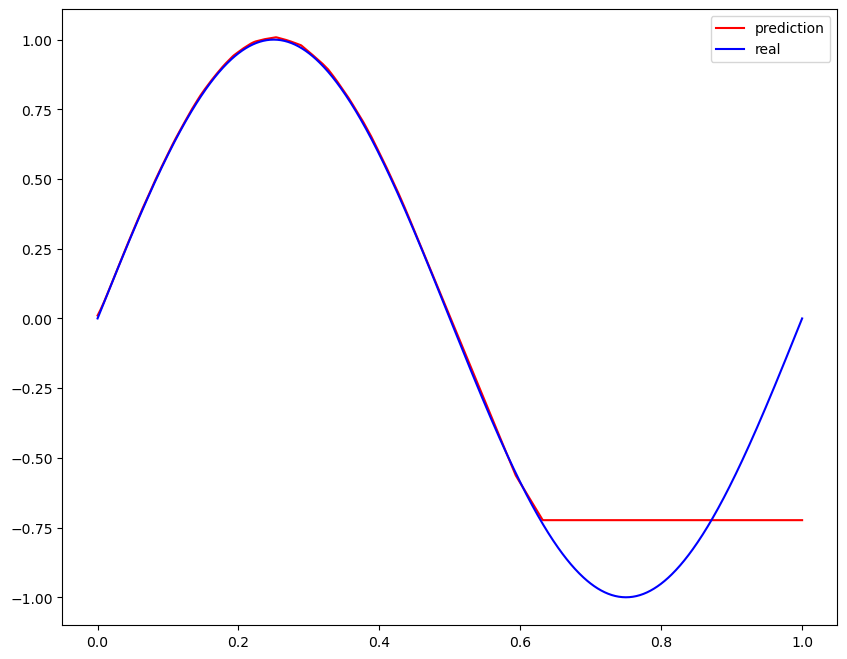

In [188]:
w1 = random_weights((1, hidden_dim[0]))
b1 = torch.zeros(1000, device=device, requires_grad=True)

w2 = random_weights((hidden_dim[0], hidden_dim[1]))
b2 = torch.zeros(100, device=device, requires_grad=True)

w3 = random_weights((hidden_dim[1], 1))
b3 = torch.zeros(1, device=device, requires_grad=True)

params = [w1, b1, w2, b2, w3, b3]

x_bare = x_bare.to(device=device)
y_bare = y_bare.to(device=device)

train_loop(x, y, three_layer_fc, params, 5e-2, iteration=20000)


### Now that we build our network with the most complicated abstraction, we can now move on to the second abstraction. 
nn.Module is not as complicated as barebones, so it's more intuitive. But because a lot of stuff is encapsulated, it's less flexible.

In [178]:
class ThreeLayerFC(nn.Module):
    def __init__(self, input_dim, hidden_dims, num_classes):
        super().__init__()
        self.fc_1 = nn.Linear(input_dim, hidden_dims[0])
        nn.init.kaiming_normal_(self.fc_1.weight)
        
        self.fc_2 = nn.Linear(hidden_dims[0], hidden_dims[1])
        nn.init.kaiming_normal_(self.fc_2.weight)

        self.fc_3 = nn.Linear(hidden_dims[1], num_classes)
        nn.init.kaiming_normal_(self.fc_3.weight)

    def forward(self, x):
        h1 = self.fc_1(x)
        h1 = F.relu(h1)
        h2 = self.fc_2(h1)
        h2 = F.relu(h2)
        out = self.fc_3(h2)
        return out

def test_ThreeLayerFC():
    model = ThreeLayerFC(1, [1000, 100], 1)
    x = torch.zeros((500, 1))
    out = model(x)
    print(out.size())

test_ThreeLayerFC()
        

torch.Size([500, 1])


### Now that we have defined a subclass of nn.Module (which is our own model), we can now proceed to use that to train a three layer neural network.
As usual, we need to define a training function. 

Iteration 0, loss = 1.133974
Iteration 1, loss = 215.791763
Iteration 2, loss = 4.907842
Iteration 3, loss = 70.515381
Iteration 4, loss = 69.637787
Iteration 5, loss = 50.371449
Iteration 6, loss = 28.982588
Iteration 7, loss = 13.076946
Iteration 8, loss = 4.132932
Iteration 9, loss = 0.827192
Iteration 10, loss = 0.505897
Iteration 11, loss = 0.494063
Iteration 12, loss = 0.476883
Iteration 13, loss = 0.454584
Iteration 14, loss = 0.427423
Iteration 15, loss = 0.405127
Iteration 16, loss = 0.393805
Iteration 17, loss = 0.389964
Iteration 18, loss = 0.395004
Iteration 19, loss = 0.398984
Iteration 20, loss = 0.405114
Iteration 21, loss = 0.407845
Iteration 22, loss = 0.408854
Iteration 23, loss = 0.408129
Iteration 24, loss = 0.404980
Iteration 25, loss = 0.401945
Iteration 26, loss = 0.397936
Iteration 27, loss = 0.351833
Iteration 28, loss = 0.288477
Iteration 29, loss = 0.213030
Iteration 30, loss = 0.156391
Iteration 31, loss = 0.138978
Iteration 32, loss = 0.163255
Iteration 33,

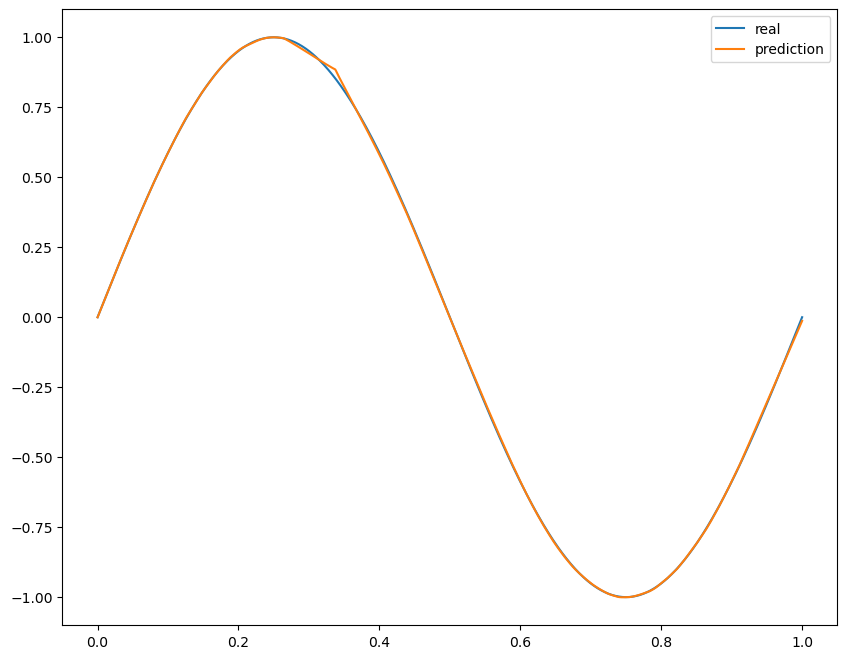

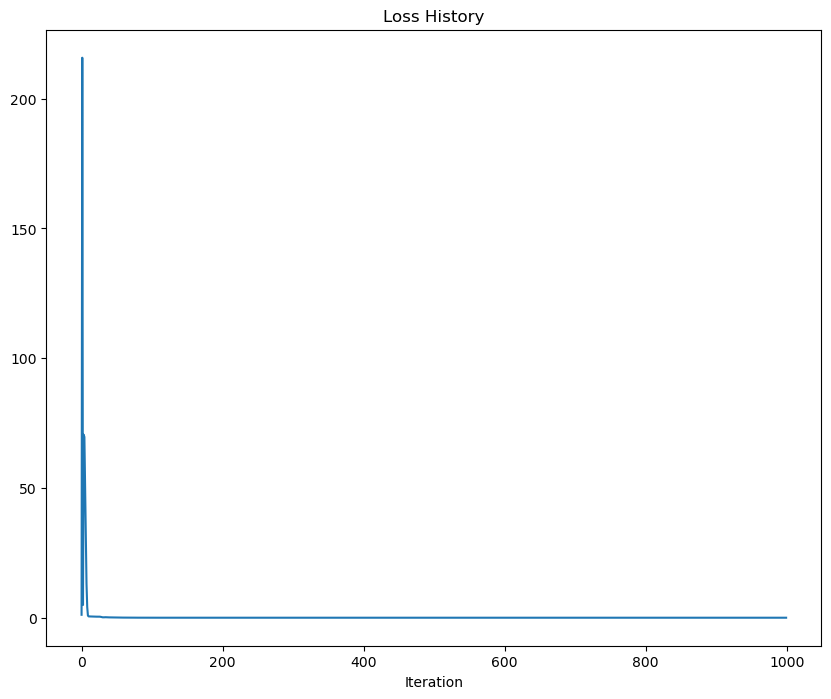

In [189]:
x_module = torch.linspace(0, 1, steps=1000, device=device).reshape(1000, 1)
y_module = torch.sin(2 * torch.pi * x)

loss_his = []

def train(model, optimizer, iteration=1000):
    model = model.to(device)
    for i in range(iteration):
        y_pred = model(x_module)
        loss = F.mse_loss(y_pred, y_module)
        loss_his.append(loss.item())

        # Zero out all the gradient before compute the gradient
        optimizer.zero_grad()

        # Backward pass the loss, compute the gradient with respect to each parameter  of the model.
        loss.backward()
        # Use step to update the parameters of the model
        optimizer.step()

        print("Iteration %d, loss = %f" % (i, loss.item()))
    
    y_pred_np = y_pred.to(torch.device('cpu')).detach().numpy()
    x_np = x.to(torch.device('cpu')).detach().numpy()
    y_np = y.to(torch.device('cpu')).detach().numpy()

    plt.plot(x_np, y_np, label="real")
    plt.plot(x_np, y_pred_np, label="prediction")
    plt.legend(loc="best")
    plt.show()

model = ThreeLayerFC(1, [1000, 100], 1)
optimizer = optim.Adam(model.parameters(), lr=1e-2)
train(model, optimizer)
plt.title("Loss History")
plt.xlabel("Iteration")
plt.plot(loss_his)
plt.show()


### Now that we've tried with the previous two flavors, let's try the third abstraction. The Powerful Sequential!

Iteration 0, loss = 0.503212
Iteration 1, loss = 1.631293
Iteration 2, loss = 10.124978
Iteration 3, loss = 0.503208
Iteration 4, loss = 1.334982
Iteration 5, loss = 2.348177
Iteration 6, loss = 1.805536
Iteration 7, loss = 0.856779
Iteration 8, loss = 0.368470
Iteration 9, loss = 0.396739
Iteration 10, loss = 0.636865
Iteration 11, loss = 0.809839
Iteration 12, loss = 0.808597
Iteration 13, loss = 0.696940
Iteration 14, loss = 0.533845
Iteration 15, loss = 0.384995
Iteration 16, loss = 0.285172
Iteration 17, loss = 0.239850
Iteration 18, loss = 0.236807
Iteration 19, loss = 0.255744
Iteration 20, loss = 0.280978
Iteration 21, loss = 0.301731
Iteration 22, loss = 0.310114
Iteration 23, loss = 0.303934
Iteration 24, loss = 0.285565
Iteration 25, loss = 0.259713
Iteration 26, loss = 0.231525
Iteration 27, loss = 0.205401
Iteration 28, loss = 0.184272
Iteration 29, loss = 0.169416
Iteration 30, loss = 0.160643
Iteration 31, loss = 0.157150
Iteration 32, loss = 0.157679
Iteration 33, loss 

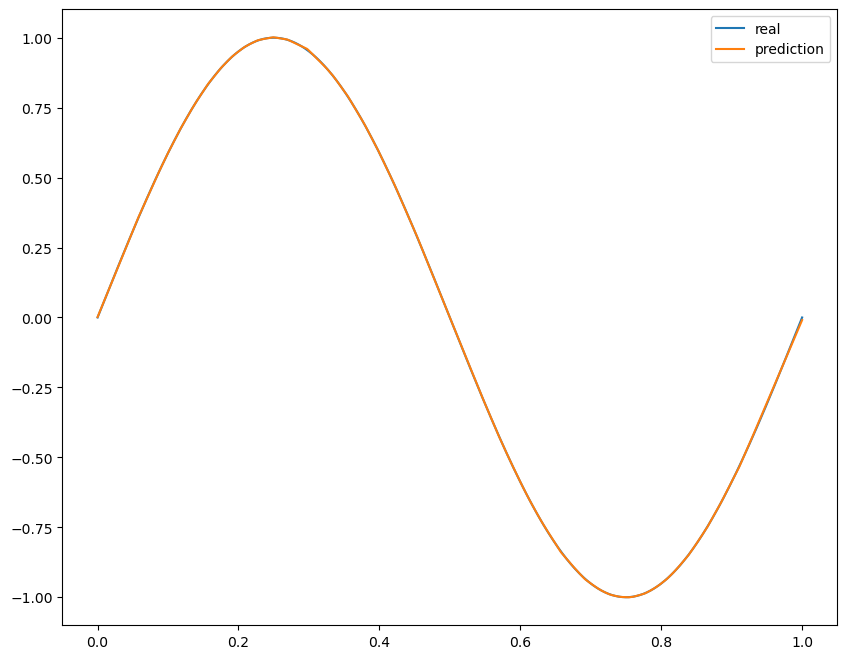

In [190]:
hidden_dims = [1000, 100]
x_sequential = torch.linspace(0, 1, steps=1000, device=device).reshape(1000, 1)
y_sequential = torch.sin(x)

model = nn.Sequential(
    nn.Linear(1, hidden_dims[0]),
    nn.ReLU(),
    nn.Linear(hidden_dims[0], hidden_dims[1]),
    nn.ReLU(),
    nn.Linear(hidden_dims[1], 1)
)

optimizer = optim.Adam(model.parameters(), lr=1e-2)
train(model, optimizer)